# Finding trending issues on the SF311 dataset

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## The time window to bucket samples
TIME_RANGE = '30min'

## File path
DATAPATH = "SF311_simplified.csv"


#### Turn a raw CSV file into a time series we can model using some utils from moda

In [10]:
from moda.dataprep.raw_to_ts import raw_to_ts
from moda.dataprep.ts_to_range import ts_to_range

def raw_to_timeseries(datapath, time_range='30min', nrows=None, min_date=None, max_date=None, save_files=False):

    if nrows is None:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'])
    else:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'], nrows=nrows)

    raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})

    # Create a time series dataframe
    ts = raw_to_ts(raw, min_date=min_date, max_date=max_date)

    # Divide time series to ranges and categories
    ranged_ts = ts_to_range(ts, time_range=time_range)

    if save_files:
        if nrows is None:
            ts.to_csv("ts.csv")
            ranged_ts.to_csv("ranged_ts.csv")
        else:
            ts.to_csv("ts_" + str(nrows) + "_rows.csv")
            ranged_ts.to_csv("ranged_ts_" + str(nrows) + "_rows.csv")
    return ranged_ts

### Read a sample from the SF 311 data
Limiting the number of rows as this is a pretty big file

In [11]:
ranged_ts = raw_to_timeseries(DATAPATH,time_range=TIME_RANGE)

C:\ProgramData\Anaconda3\lib\site-packages\moda-0.0.2-py3.6.egg\moda\dataprep\ts_to_range.py:17: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  range_grp = ts.groupby([pd.TimeGrouper(time_range), 'category']).agg('count')


#### A time series in moda has a MultiIndex, comprised of the date and the category.


In [12]:
print(len(ranged_ts))
print(ranged_ts.index.get_level_values('date').min())
print(ranged_ts.index.get_level_values('date').max())

1206854
2008-07-01 00:00:00
2018-08-25 00:30:00


In [13]:
#Let's look which categories appear the most. We remove the index just for the EDA
flat = ranged_ts.reset_index()

#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
from dfply import *

categories = flat >> group_by(X.category) >> \
    summarise(value = np.sum(X.value)) >> \
    ungroup() >> \
    arrange(X.value,ascending=False)


categories.head(10)

,category,value
98,Street and Sidewalk Cleaning,869024
83,Graffiti,457827
88,MUNI Feedback,198420
1,Abandoned Vehicle,194940
84,Homeless Concerns,160384
8,Encampments,143778
7,Damaged Property,94857
94,Sewer Issues,78686
93,SFHA Requests,68660
101,Tree Maintenance,67409


## Most discussed categories

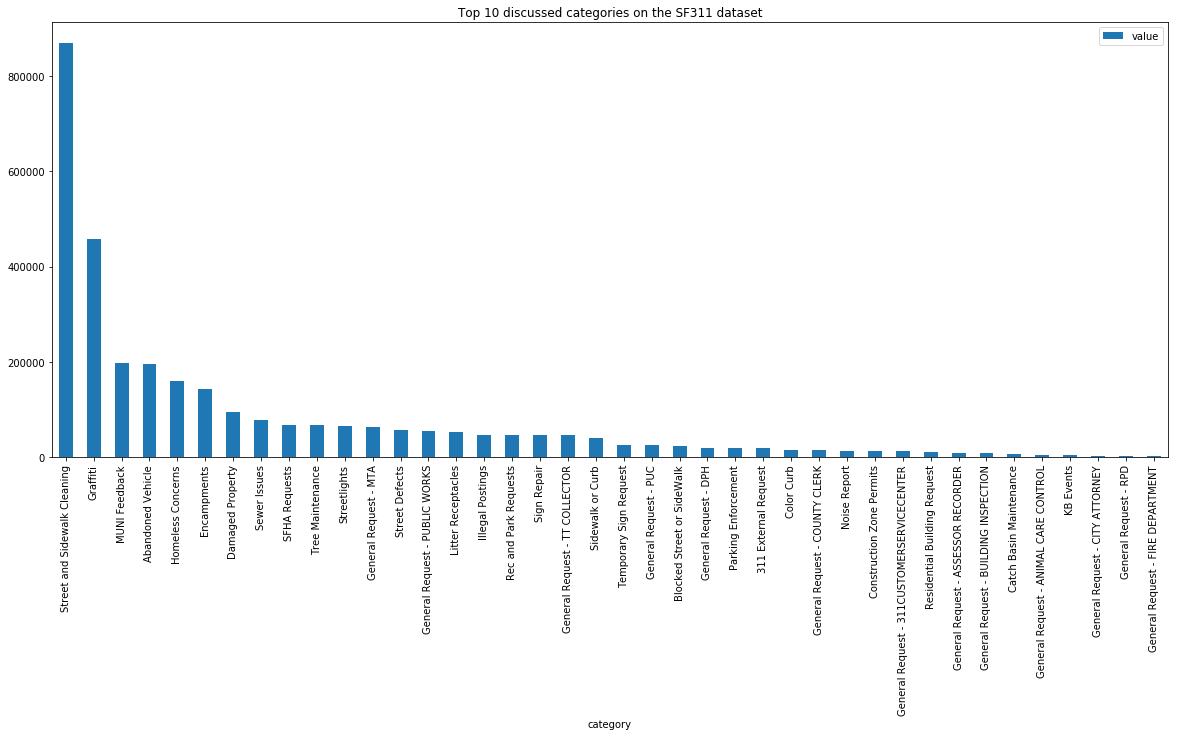

In [14]:
categories.head(40).plot(kind='bar',x='category',title="Top 10 discussed categories on the SF311 dataset",figsize=(20,8))

## Time series inspection
### Selecting the biggest category, Street and Sidewalk Cleaning, just for inspection

In [32]:
street_cleaning = ranged_ts.loc[pd.IndexSlice[:, 'Street and Sidewalk Cleaning'], :].reset_index(level='category', drop=True)
# street_cleaning = street_cleaning[street_cleaning.index.get_level_values('date') < '2008-10-01']
street_cleaning.head()

,value
date,
2008-07-01 00:00:00,2
2008-07-01 03:00:00,1
2008-07-01 05:00:00,3
2008-07-01 06:00:00,6
2008-07-01 06:30:00,3


In [37]:
print(len(street_cleaning))
print(street_cleaning.index.get_level_values('date').min())
print(street_cleaning.index.get_level_values('date').max())

128415
2008-07-01 00:00:00
2018-08-23 00:30:00


In [39]:
street_cleaning_flat.reset_index()[street_cleaning['date']> '2018-01-01']

KeyError: 'date'

### Time series plot

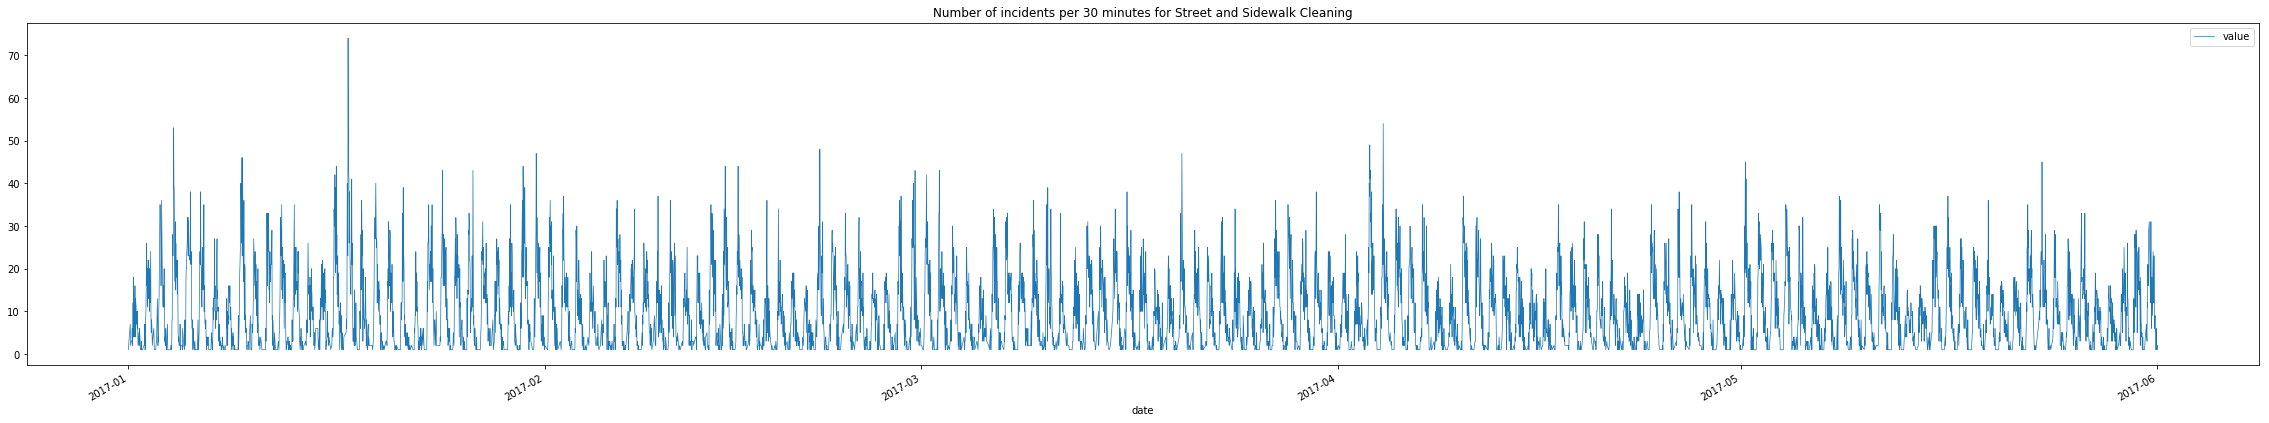

In [46]:
START = '2017-01-01'
END = '2017-06-01'
street_cleaning_flat = street_cleaning.reset_index()
street_cleaning_flat = street_cleaning_flat[(street_cleaning_flat['date'] > START) & (street_cleaning_flat['date']<=END)]
street_cleaning_flat.plot(kind='line',x='date',y='value',figsize=(40,7),linewidth=0.7, title = "Number of incidents per 30 minutes for Street and Sidewalk Cleaning")

# Unsupervised anomaly detection on the street_cleaning using LSTM on Keras
#### Train/Test split

In [47]:
train_percent = 70
datetimeindex = street_cleaning.index
num_dates = len(datetimeindex)

train = street_cleaning.loc[datetimeindex[:int(num_dates * train_percent / 100)]]
test = street_cleaning.loc[datetimeindex[int(num_dates * train_percent / 100):]]

print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

Training set length = 89890, Test set length = 38525


#### Pad train and test with zeros where dates are missing

In [48]:
train = train.resample(TIME_RANGE, convention='start').asfreq().fillna(0)
test = test.resample(TIME_RANGE, convention='start').asfreq().fillna(0)
print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

from sklearn.utils import shuffle
train = shuffle(train)

Training set length = 131780, Test set length = 46062


Scale values

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

scaled_values_train = scaler.fit_transform(train['value'].values.reshape(-1, 1))
train_scaled = pd.DataFrame(index = train.index)
train_scaled['value'] = scaled_values_train

scaled_values_test = scaler.fit_transform(test['value'].values.reshape(-1, 1))
test_scaled = pd.DataFrame(index = test.index)
test_scaled['value'] = scaled_values_test

print("Train length=" + str(len(train_scaled)))
train_scaled.head()

Train length=131780


,value
date,
2010-06-03 12:30:00,-0.906977
2009-03-26 21:30:00,-1.000000
2015-08-29 14:30:00,-0.844961
2008-10-29 20:00:00,-0.922481
2009-06-09 12:30:00,-0.937984


### Plot train and test time series

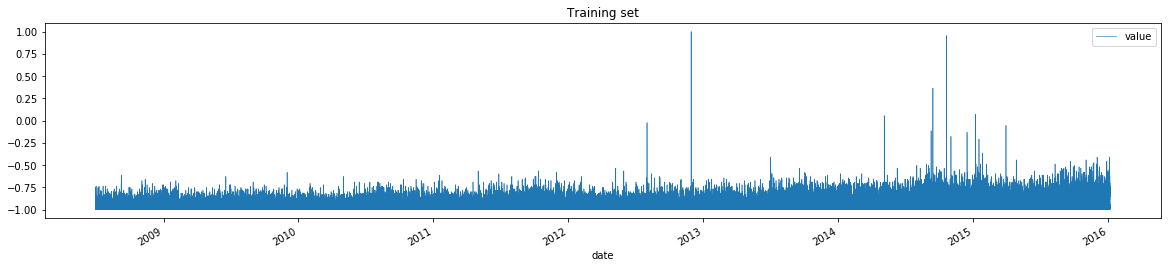

In [50]:
train_scaled.reset_index().plot(kind='line',x='date',y='value',figsize=(20,4),linewidth=0.6, title = "Training set")

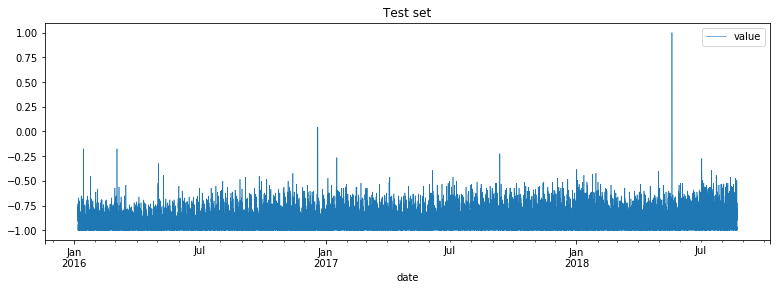

In [51]:
test_scaled.reset_index().plot(kind='line',x='date',y='value',figsize=(13,4),linewidth=0.6, title = "Test set")

In [87]:
# Prep series for modeling by creating windows of size window_size

window_size = 128

# Train
train_samples = train_scaled.copy()
for i in range(window_size):
    train_scaled = pd.concat([train_scaled,train_samples.shift(-(i+1))],axis=1)
train_scaled = train_scaled.dropna(axis=0)


# Test
test_samples = test_scaled.copy()
for i in range(window_size):
    test_scaled = pd.concat([test_scaled,test_samples.shift(-(i+1))],axis=1)
test_scaled = test_scaled.dropna(axis=0)

print("Train length={0}, Test length={1}".format(len(train_scaled),len(test_scaled)))

train_scaled.head()

MemoryError: 

In [ ]:
test_scaled.head()

In [ ]:
train_X = train_scaled.iloc[:,:-1].values
train_y = train_scaled.iloc[:,-1].values
test_X = test_scaled.iloc[:,:-1].values
test_y = test_scaled.iloc[:,-1].values

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

print("train_X dim={0}, train_y dim={1}, test_X dim={2}, test_y dim={3}".format(train_X.shape,train_y.shape,test_X.shape,test_y.shape))

In [ ]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D
from keras.layers.core import Dense, Activation, Dropout


model = Sequential()
model.add(Conv1D(input_shape = (window_size,1),filters=32,kernel_size=10))
model.add(LSTM(128, output_dim= window_size, return_sequences = False))
#model.add(LSTM(32, return_sequences = False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

In [ ]:
import time

start = time.time()
model.fit(train_X,train_y,batch_size=256,epochs=3,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

In [83]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X)

MSE=0.007395746584305329


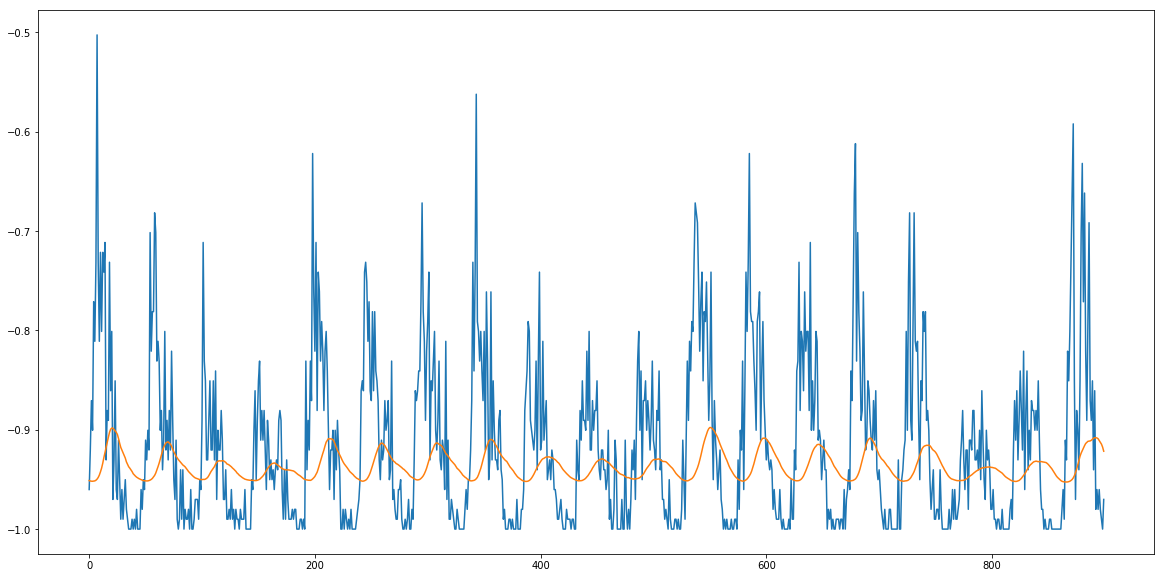

In [84]:
from sklearn.metrics import mean_squared_error

window = range(10100,11000)


actual = test_y[window]
prediction = preds[window]
print("MSE="+str(mean_squared_error(actual,prediction)))
plt.figure(figsize=(20,10))
plt.plot(actual)
plt.plot(prediction)